## networkMDE examples

### representing a knn

This part is dedicated to the representation of a k-nearest-neighbours network from a 4D space to a 2D embedding space.
A knn is best represented by a directed graph (networkMDE.network.dirNetwork).

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import cnets # this is part of the networkMDE package
from networkMDE.network import dirNetwork
from networkMDE import netplot

# set the seeds for reproducibility
np.random.seed(42)
cnets.set_seed(42)

# wurlitzer is needed to show C stdout/stderr outputs from cnets
# (only in jupyter notebooks)
%load_ext wurlitzer

Now generate random points in a 4D space and set their values as their first coordinate. This helps to visualize if the representation in a lower dimensional space is done in a more or less correct way.
Then generate the knn network, say, of the first 5 neighbours.

In [11]:
points = np.random.uniform(-1,1, size=(500,4))
values = points[:,0]

sparse_matrix = cnets.stupid_knn(points.tolist(), # note: first argument must be a python list
                                5)
print() # somehow jupyter notebooks mess up outputs
net = dirNetwork.from_sparse(sparse_matrix)
net.values = values


cnets - INFO: requested knn with k = 5 of 500 objects in R4
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|99 %K
cnets - INFO: stupid_knn done.
Network has 500 elements and 2499 links (density =  2.0 %)


Now specify the dimension of the embedding space (only 2d and 3d can be represented, obviously) and find the less distortive embedding.
The MDE procedure (at the moment) consists of adjusting the position of each node *attracting* the childs and *repelling* random non-childs.
The three cMDE parameters are:
-  *attractive* factor(s)
-  *repulsive* factor(s)
-  *number* of steps(s)

As a rule of thumb, the best performances can be obtained first performing a short repelling run ( 1.0, 0.5, 10) then a longer and less repulsive one (0.5, 0.01, 1000) and then a long nonrepulsive final stage (0.1, 0.0, 10000)

In [15]:
net.initialize_embedding(dim=2)
# note: first argument is a list of attractive factors, the second a list of repulsive ones and third a list of steps
net.cMDE([1.0, 0.5, 0.1], [0.5, 0.01, 0.0], [10, 1000, 3000])

cnets - INFO: Generating network...	Done.
cnets - INFO: Random initialization in R2...	Done.
cnets - INFO: starting MDE with eps = 1.000, neg_eps = 0.500, Nsteps = 10
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒     |90 % (D = 233.5812)2K
cnets - INFO: MDE end
cnets - INFO: starting MDE with eps = 0.500, neg_eps = 0.010, Nsteps = 1000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|98 % (D = 9.0062)KK
cnets - INFO: MDE end
cnets - INFO: starting MDE with eps = 0.100, neg_eps = 0.000, Nsteps = 3000
|▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒|99 % (D = 0.0284)K
cnets - INFO: MDE end


The final distortion of each run is printed in yellow (D = ...). 

With a low number of neighbours (very local topology) and with an initial space dimension <~= 20 a good distortion is tipically <~ 0.2

Plot the network. If the nodes' coloring has some kind of pattern the knn representation is informative.

Plot started:
Getting graphics..	Done.
Updating scatter..	Done.
Updating lines..	Done.


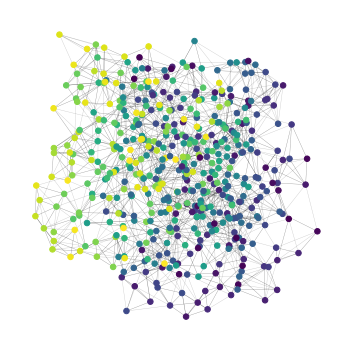

In [16]:
netplot.plot_lines = True # the denser the network, the more time-expensive plotting lines is
netplot.plot_net(net)
plt.show()

To see how much is the mean distortion of the netwok:

In [17]:
cnets.get_distortion()

0.02836441434919834

Note that `cnets` can handle only one network at a time, so after `initialize_embedding` each cnets call refers to the last initialized network.